In [1]:
import torch
# makes default tensor a CUDA tensor so GPU can be used
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

from lenet import LeNet
import torchvision
import torchvision.datasets as datasets
from interpretation_attacks import SimpleGradientsAttack
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Load network to attack and create Dataloader 

```net``` is the original network, and ```net_proxy``` is the network that we use to create the attack. The ```net_proxy``` is only different from ```net``` in its activations: the softplus activation function of ```net_proxy``` is second-order differentiable, unlike the relu activation function in ```net```.

In [2]:
net = LeNet(activation=torch.nn.functional.relu)
net_proxy = LeNet(activation=torch.nn.functional.softplus)

epsilon = 0
alpha_wd = 0
alpha_jr = 0
training_round = 1
net_name = f'models/training_round_{training_round}/ep{epsilon}_wd{alpha_wd}_jr{alpha_jr}_{training_round}'

net.load_state_dict(torch.load(net_name))
net_proxy.load_state_dict(torch.load(net_name))

net.eval()
net_proxy.eval()

data_preprocess = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(), 
                torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST(root='./data', train=True, transform=data_preprocess), 
                batch_size=1, shuffle=True)

### Load a random training sample from the training set and perturb it

```sample``` is the original sample and ```label``` is the correct label associated with it. ```saliency_map``` is the saliency map associated with ```net```'s prediction for ```sample```. ```sample_``` and ```saliency_map_``` are the perturbed counterparts.

In [5]:
sample,label = next(iter(train_loader))
sample,label = sample.to(device),label.to(device)

sga = SimpleGradientsAttack(net, net_proxy, sample, label, top_k=100, device=device)
saliency_map = sga.og_saliency

sample_ = sga.iterative_attack(sample, attack_method='top_k', alpha=.001, num_iters=300)
saliency_map_ = sga.create_saliency_map(net, sample_, used=False)

iteration #0
iteration #20
iteration #40
iteration #60
iteration #80
iteration #100
iteration #120
iteration #140
iteration #160
iteration #180
iteration #200
iteration #220
iteration #240
iteration #260
iteration #280


### Display the origial and perturbed samples and the corresponding saliency maps

		lenet(sample) = 0 	lenet(sample*) = 0


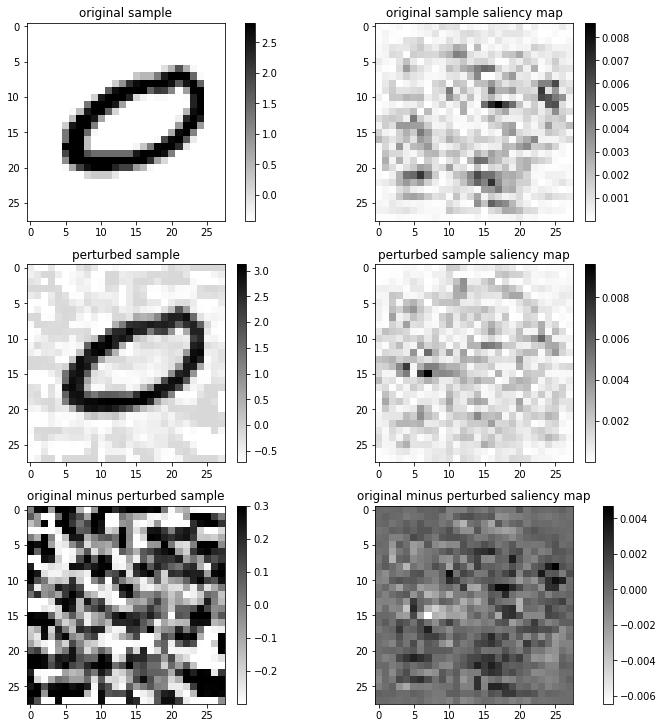

In [6]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

print(f'\t\tlenet(sample) = {label.item()} \tlenet(sample*) = {torch.argmax(net(sample_))}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('original sample')
plt.imshow(sample.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('original sample saliency map')
plt.imshow(saliency_map.cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax3 = fig.add_subplot(spec[1,0])
ax3.title.set_text('perturbed sample')
plt.imshow(sample_.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax4 = fig.add_subplot(spec[1,1])
ax4.title.set_text('perturbed sample saliency map')
plt.imshow(saliency_map_.cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax5 = fig.add_subplot(spec[2,0])
ax5.title.set_text('original minus perturbed sample')
plt.imshow((sample-sample_).squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax6 = fig.add_subplot(spec[2,1])
ax6.title.set_text('original minus perturbed saliency map')
plt.imshow((saliency_map-saliency_map_).cpu().detach().numpy(), cmap='binary')
plt.colorbar()

plt.show()